In [486]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants, integrate, interpolate
import pandas as pd
from astropy import units as u
from astropy.constants import h, c, k_B

from setplot import set_plot_style

set_plot_style()

class PhotometricSystem:
    """
    Classe per gestire sistemi fotometrici (Vega e AB) e conversioni tra loro.
    """
    def __init__(self):
        # Definizione dei sistemi e filtri disponibili
        self.MAG_SYSTEMS = ["Vega", "AB"]
        
        self.filters_vega = ["U", "B", "V", "R", "I", "J", "H", "K"]
        self.ab_vega_diff_vf = [0.79, -0.09, 0.02, 0.21, 0.45, 0.91, 1.39, 1.85]
        
        self.filters_AB = ["u", "g", "r", "i", "z"]
        self.ab_vega_diff_abf = [0.91, -0.08, 0.16, 0.37, 0.54]
        
        # Nome dei file trasmissione filtro
        #Should we add the two filter Y and Z? ! ! !
        self.transname = {
            "U": "U",
            "B": "B",
            "V": "V",
            "R": "R",
            "I": "I",
            "J": "J",
            "H": "H",
            "K": "K",
            "uprime": "u",
            "gprime": "g",
            "rprime": "r",
            "iprime": "i",
            "zprime": "z"
        }
        
        # Punti zero per Vega
        self.VEGA_flux_zeropoints = {
            "U": [3600., None, 4.18023e-9, 757.5],
            "B": [4380., None, 6.60085e-9, 1455.4],
            "V": [5450., None, 3.60994e-9, 990.4],
            "R": [6410., None, 2.28665e-9, 737.9],
            "I": [7980., None, 1.22603e-9, 492.5],
            "J": [12200., None, 3.12e-10, 191.6],
            "H": [16300., None, 1.14e-10, 93.5],
            "K": [21900., None, 3.94e-11, 43.4]
        }
        
        # Punti zero per AB
        self.AB_flux_zeropoints = {
            "u": [3560., 3631, 859.5e-11, 1539.3],
            "g": [4830., 3631, 466.9e-11, 1134.6],
            "r": [6260., 3631, 278.0e-11, 875.4],
            "i": [7670., 3631, 185.2e-11, 714.5],
            "z": [9100., 3631, 131.5e-11, 602.2]
        }
        
        # Caricamento profili dei filtri
        self.band_filters = self._load_filter_profiles()
    

    def _load_filter_profiles(self):
        """Carica i profili di trasmissione dei filtri da file."""
        filters_folder = "Band_Filters/"  # Sostituire con il percorso corretto
        band_filters = {}
        
        for filename in os.listdir(filters_folder):
            if filename.endswith(".txt"):
                with open(filters_folder + filename, 'r', encoding='latin-1') as f:
                    lines = f.readlines()
                    data = np.loadtxt([line for line in lines if not line.strip().startswith(('#', '!'))])
                    band_raw = filename[:-4]
                    band_name = self.transname[band_raw]
                    band_filters[band_name] = data
        return band_filters
                
    
    def get_flux_zeropoint(self, band, system="Vega", quantity="Fll"):
        """
        Restituisce il punto zero di flusso per un dato filtro e sistema.
        
        Parametri:
        - band: nome del filtro (es. 'U', 'g')
        - system: 'Vega' o 'AB'
        - quantity: 'Fv' [erg/cm²/s/Hz], 'Fll' [erg/cm²/s/Å], 'PHll' [photons/cm²/s/Å]
        
        Restituisce:
        - lambda_eff: lunghezza d'onda efficace [Å]
        - zeropoint: valore del punto zero nelle unità richieste
        """
        if system == "Vega":
            if band not in self.filters_vega:
                raise ValueError(f"Filtro Vega non valido. Scegli tra: {self.filters_vega}")
            zp_dict = self.VEGA_flux_zeropoints
        elif system == "AB":
            if band not in self.filters_AB:
                raise ValueError(f"Filtro AB non valido. Scegli tra: {self.filters_AB}")
            zp_dict = self.AB_flux_zeropoints
        else:
            raise ValueError("Sistema fotometrico non valido. Scegli 'Vega' o 'AB'")
        
        if quantity == "Fv":
            sel = 1
        elif quantity == "Fll":
            sel = 2
        elif quantity == "PHll":
            sel = 3
        else:
            raise ValueError("Quantità non valida. Scegli 'Fv', 'Fll' o 'PHll'")
        
        return zp_dict[band][0], zp_dict[band][sel]
    
    def convert_magnitude(self, mag, band, from_system, to_system):
        """
        Converte una magnitudine tra sistemi fotometrici.
        
        Parametri:
        - mag: valore della magnitudine
        - band: nome del filtro
        - from_system: sistema di partenza ('Vega' o 'AB')
        - to_system: sistema di arrivo ('Vega' o 'AB')
        
        Restituisce:
        - mag_converted: magnitudine convertita
        """
        if from_system == to_system:
            return mag
        
        if from_system == "Vega" and to_system == "AB":
            if band not in self.filters_AB:
                raise ValueError(f"Filtro AB non valido per conversione. Scegli tra: {self.filters_AB}")
            return mag + self.ab_vega_diff_abf[self.filters_AB.index(band)]
        
        elif from_system == "AB" and to_system == "Vega":
            if band not in self.filters_vega:
                raise ValueError(f"Filtro Vega non valido per conversione. Scegli tra: {self.filters_vega}")
            return mag - self.ab_vega_diff_vf[self.filters_vega.index(band)]
        
        else:
            raise ValueError("Conversione non supportata")

    def auto_conversion(self, mag, band, sys):
        new_sys = sys
        new_mag = mag
        if sys == "Vega":
            if band not in phot_system.filters_vega:
                new_sys = 'AB'
                new_mag = self.convert_magnitude(mag,band,sys,new_sys)
        elif sys == "AB":
            if band not in phot_system.filters_AB:
                new_sys = 'Vega'
                new_mag = self.convert_magnitude(mag,band,sys,new_sys)
        
        if new_sys != sys:
            print("wrong coupling of filter - system")
            print("Conversion:")
            print(f"{sys} > {new_sys}")
            print(f"{mag} > {new_mag}")
        return new_mag, new_sys
    

    
class SEDModels:
    
    """
    Classe per generare modelli di distribuzione spettrale di energia (SED).
    """
    @staticmethod
    def blackbody(wavelength, temperature):
        """
        Genera uno spettro di corpo nero.
        
        Parametri:
        - wavelength: array di lunghezze d'onda [Å]
        - temperature: temperatura [K]
        
        Restituisce:
        - flux: flusso [erg/s/cm²/Å]
        """
        wavelength_m = wavelength * 1e-10  # Converti Å in metri
        exponent = h.value * c.value / (wavelength_m * k_B.value * temperature)
        
        # Evita overflow per esponenti grandi
        #exponent = np.where(exponent > 100, 100, exponent)
        
        flux = (2 * h.value * c.value**2 / (wavelength_m**5 * (np.exp(exponent) - 1))) * 1e-10
        return flux * 1e7  # Converti W/m²/m in erg/s/cm²/Å
    
    @staticmethod
    def powerlaw(wavelength, slope, norm_wavelength=5500, norm_flux=1.0):
        """
        Genera uno spettro con legge di potenza.
        
        Parametri:
        - wavelength: array di lunghezze d'onda [Å]
        - slope: indice della legge di potenza
        - norm_wavelength: lunghezza d'onda di normalizzazione [Å]
        - norm_flux: flusso alla lunghezza d'onda di normalizzazione
        
        Restituisce:
        - flux: flusso normalizzato
        """
        return norm_flux * (wavelength / norm_wavelength)**slope
    
    #We could add the asymmetric gaussian in principle ! ! !
    @staticmethod
    def gaussian_line(wavelength, center, flux, fwhm):
        """
        Genera una linea spettrale gaussiana.
        
        Parametri:
        - wavelength: array di lunghezze d'onda [Å]
        - center: centro della linea [Å]
        - flux: flusso integrato della linea [erg/s/cm²]
        - fwhm: larghezza a metà altezza [Å]
        
        Restituisce:
        - flux: flusso [erg/s/cm²/Å]
        """
        sigma = fwhm / 2.355
        exponent = -0.5 * ((wavelength - center) / sigma)**2
        return (flux / (sigma * np.sqrt(2 * np.pi))) * np.exp(exponent)
    
    @staticmethod
    #we could add some kind of smoothing here ! ! !
    def interpolate_spectrum(wavelength, target_wavelength, flux):
        """
        Interpola uno spettro su nuove lunghezze d'onda.
        
        Parametri:
        - wavelength: lunghezze d'onda originali [Å]
        - target_wavelength: lunghezze d'onda target [Å]
        - flux: flusso originale [qualunque unità]
        
        Restituisce:
        - flux_interp: flusso interpolato
        """
        return np.interp(target_wavelength, wavelength, flux)
    
    @staticmethod
    def template(filename, waveunit='AA', unitsf = 'Fll'):
        """
        Reads a two-column file, skipping lines that start with '#' or '!'.
        waveunit can be 'AA' (default) or 'nm', il else it keeps AA
        """
        with open(filename, 'r', encoding='latin-1') as f:
            lines = f.readlines()
    
        # Filtra le righe che non iniziano con "#" o "!"
        data = np.loadtxt([line for line in lines if not line.strip().startswith(('#', '!'))])
        wave = data[:, 0]
        flux = data[:, 1]
        tem = filename.split('.')[0]
        tem = tem.split('/')[1]
            
        if waveunit == 'nm':
            wave *= 10
            
        if unitsf == 'PHll':
            flux  = 1.98644746e-08 * (flux / wave)
        return tem, wave, flux
        
        

class FilterManager:
    """
    Classe per gestire filtri e normalizzazioni.
    """
    def __init__(self, phot_system):
        self.phot_system = phot_system
    
    def get_filter_profile(self, band):
        """
        Restituisce il profilo di trasmissione di un filtro.
        
        Parametri:
        - band: nome del filtro
        
        Restituisce:
        - wavelength: lunghezze d'onda [Å]
        - transmission: trasmissione [0-1]
        """
        if band not in self.phot_system.band_filters:
            raise ValueError(f"Filtro {band} non trovato")
        return self.phot_system.band_filters[band].T[0], self.phot_system.band_filters[band].T[1]
    
    def apply_filter(self, wavelength, flux, band, mag=None, system="Vega", typeSP = "Fll"):
        """
        Applica un filtro a uno spettro e normalizza a una magnitudine.
        
        Parametri:
        - wavelength: lunghezze d'onda dello spettro [Å]
        - flux: flusso dello spettro [erg/s/cm²/Å]
        - band: nome del filtro
        - mag: magnitudine target (None per non normalizzare)
        - system: sistema fotometrico ('Vega' o 'AB')
        
        Restituisce:
        - filtered_flux: flusso filtrato e normalizzato
        """
        # Ottieni profilo filtro
        filt_wave, filt_trans = self.get_filter_profile(band)
        
        # Interpola spettro e filtro su una griglia comune
        min_wave = max(wavelength.min(), filt_wave.min())
        max_wave = min(wavelength.max(), filt_wave.max())
        common_wave = np.linspace(min_wave, max_wave, 1000)
        
        flux_interp = SEDModels.interpolate_spectrum(wavelength, common_wave, flux)
        trans_interp = SEDModels.interpolate_spectrum(filt_wave, common_wave, filt_trans)
        
        # Applica il filtro
        filtered_flux = flux_interp * trans_interp #questo da correggere, perché va bene solo con integrale 1?
        
        # Normalizza se richiesto
        if mag is not None:
            # Ottieni punto zero
            _, zp_ph = self.phot_system.get_flux_zeropoint(band, system, typeSP)
            zp_ph_scaled = zp_ph * (2.512**(-mag))
            
            # Calcola fattore di normalizzazione
            integral_flux = integrate.trapezoid(filtered_flux, common_wave)
            integral_trans = integrate.trapezoid(trans_interp, common_wave)
            
            K = (zp_ph_scaled * integral_trans) / integral_flux
            filtered_flux *= K 
        
        return common_wave, filtered_flux, K

#plot for comparisons
def plot_spectra_comparison(wave_coarse, flux_coarse, wave, flux, 
                             label_coarse, label, title=None, namepng=None):
    """
    Plots the coarse spectrum, interpolated fine spectrum, and original fine spectrum for comparison.
    """
    
    flux_interpolated = sed_models.interpolate_spectrum(wavelength=wave,
                                    target_wavelength=wave_coarse, flux=flux)
    
    #to ensure it works also for the zeros
    mask = (flux_interpolated != 0) & (flux_coarse != 0)
    relative_diff = np.zeros_like(flux_interpolated)  # Inizializza con zeri
    relative_diff[mask] = (flux_interpolated[mask] - flux_coarse[mask]) / flux_interpolated[mask] * 100
    
    #old one
    #relative_diff = (flux_interpolated - flux_coarse) / flux_interpolated * 100
    mean_diff = np.mean(relative_diff)
    std_diff = np.std(relative_diff)
    
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]})
    
    # --- Upper plot: Spectra ---
    ax[0].plot(wave_coarse, flux_coarse, 'o-', markersize=0, label=label_coarse, color='blue', alpha = 0.5)
    ax[0].plot(wave_coarse, flux_interpolated, 's--', markersize=0, label=label, color='red', alpha = 0.5)
    ax[0].set_ylabel("Flux density [erg cm$^{-2}$ s$^{-1}$ \u00c5$^{-1}$]")
    ax[0].legend()
    ax[0].set_title(title if title else "Spectra Comparison")
    ax[0].grid()
    
    # --- Lower plot: Relative Difference ---
    ax[1].plot(wave_coarse, relative_diff, 'o-', markersize=0, color='black',
              label=f"Mean: ({mean_diff:.2f}±{std_diff:.2f})%")
    ax[1].axhline(0, color='gray', linestyle='--', lw=1)
    ax[1].set_ylabel("Relative Diff (%)")
    ax[1].set_xlabel("Wavelength [\u00c5]")
    ax[1].legend()
    ax[1].grid()
    
    if namepng is not None:
        plt.savefig(f"{namepng}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [487]:
phot_system = PhotometricSystem()
sed_models = SEDModels()
filter_manager = FilterManager(phot_system)

### TEMPLATES

<IPython.core.display.Javascript object>


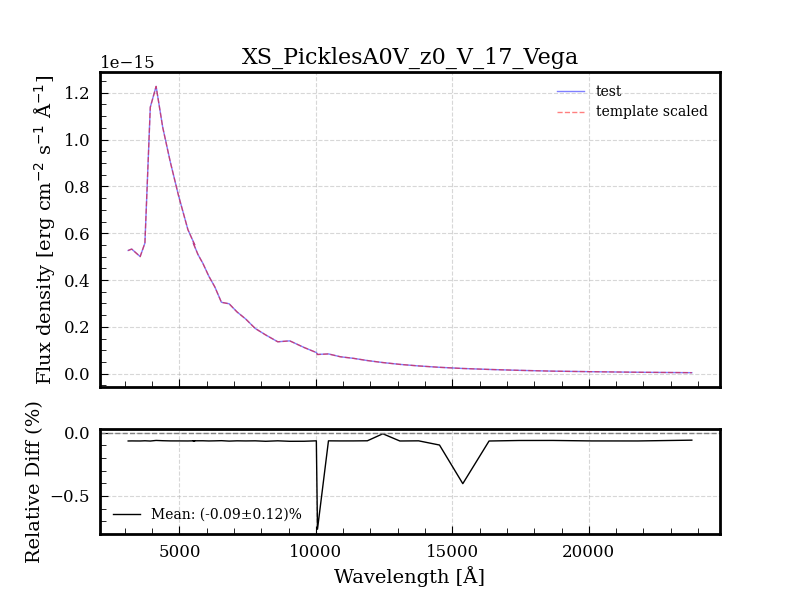

In [517]:
%matplotlib notebook
nameT, waveT, fluxT =  sed_models.template('spectra_to_test/', 
                                           waveunit='nm')

#### PARAMETERS
name, wave, flux =  sed_models.template('ESO_original_spectra/Pickles_A0V.dat')
redshift = 0
band = 'V'
mag = 17
syst = 'Vega'
###############


mag, syst = phot_system.auto_conversion(mag, band, syst)

#redshift correction
wave *= (1+redshift)

_, _, K = filter_manager.apply_filter(wave, flux, band, mag, syst)
plot_spectra_comparison(waveT, fluxT, wave, flux*K, 'test','template scaled', nameT, namepng=nameT)

### BLACKBODY

In [462]:
#A wide range to ensure the normalization to work correctly in every filter of choice 
DEFAULT_WAVE = np.linspace(100,30000,10000)

<IPython.core.display.Javascript object>


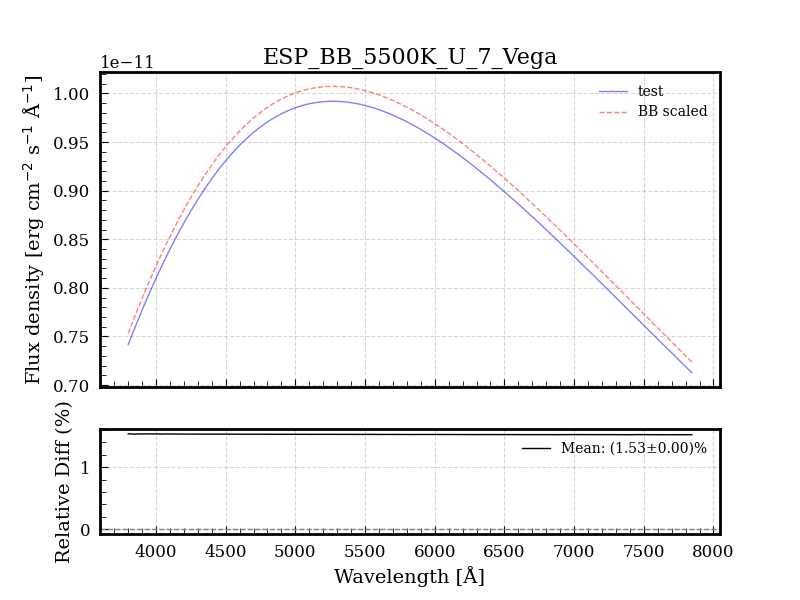

In [523]:
%matplotlib notebook
nameT, waveT, fluxT =  sed_models.template('spectra_to_test/ESP_BB_5500K_U_7_Vega.txt', 
                                           waveunit='nm')

#### PARAMETERS
band = 'U'
mag = 7
syst = 'Vega'
tmp = 5500
###############


flux =  sed_models.blackbody(DEFAULT_WAVE,tmp)

mag, syst = phot_system.auto_conversion(mag, band, syst)

_, _, K = filter_manager.apply_filter(DEFAULT_WAVE, flux, band, mag, syst)

plot_spectra_comparison(waveT, fluxT, DEFAULT_WAVE, flux*K, 'test','BB scaled', nameT, namepng=nameT)

### POWERLAW

wrong coupling of filter - system
Conversion:
AB > Vega
7 > 7.09


<IPython.core.display.Javascript object>


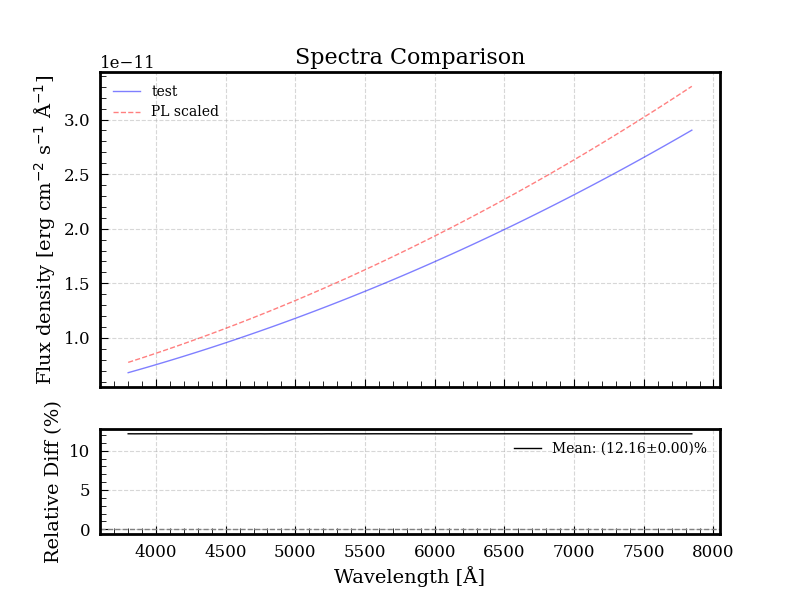

In [529]:
%matplotlib notebook
nameT, waveT, fluxT =  sed_models.template('spectra_to_test/ESP_PL_2_B_7_AB.txt', 
                                           waveunit='nm')

#### PARAMETERS
band = 'B'
mag = 7
syst = 'AB'
indpl = 2
###############


flux =  sed_models.powerlaw(DEFAULT_WAVE, indpl)

mag, syst = phot_system.auto_conversion(mag, band, syst)

_, _, K = filter_manager.apply_filter(DEFAULT_WAVE, flux, band, mag, syst)

plot_spectra_comparison(waveT, fluxT, DEFAULT_WAVE, flux*K, 'test','PL scaled', namepng=nameT)

### LINE

<IPython.core.display.Javascript object>


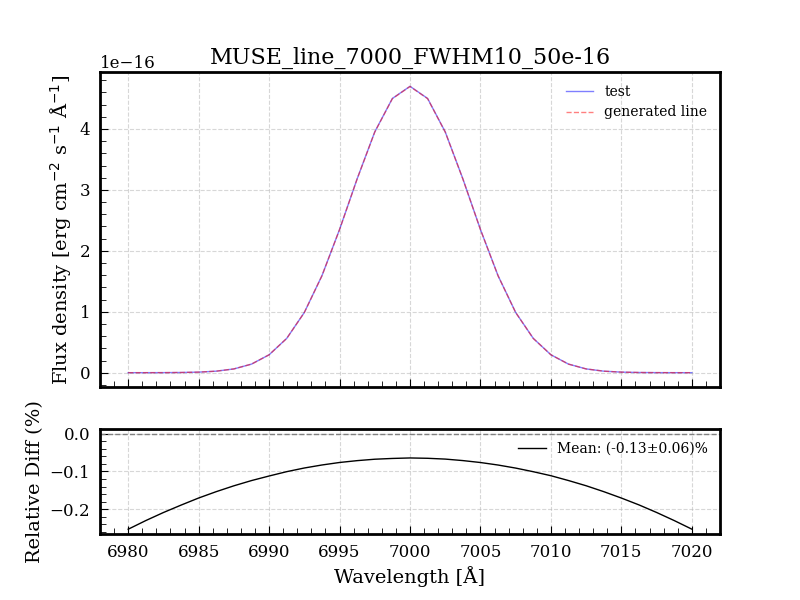

In [528]:
%matplotlib notebook
nameT, waveT, fluxT =  sed_models.template('spectra_to_test/MUSE_line_7000_FWHM10_50e-16.txt', 
                                           waveunit='nm', unitsf='PHll')
#### PARAMETERS
center = 7000 #in AA
fwhm = 10 #in AA
fwhm_mult = 2 #how much to draw around the center in times of FWHM
tot_flux = 50e-16 #in erg / cm^2 s
###############

tolerance = fwhm_mult * fwhm
fluxT = fluxT[(waveT >= center - tolerance) & (waveT <= center + tolerance)]
waveT = waveT[(waveT >= center - tolerance) & (waveT <= center + tolerance)]

flux = sed_models.gaussian_line(waveT, center, tot_flux, fwhm)

plot_spectra_comparison(waveT, fluxT, waveT, flux, 'test','generated line', nameT, namepng=nameT)